In [1]:
import torch
import pandas as pd
from network.network import PatientClassificationNet, PatientGroupNet
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
num_class = 5
num_full = 36

In [3]:
class_boundary = torch.Tensor([0.0216, 0.0470, 0.0711, 0.1185, 1.])
temp = PatientClassificationNet(21, 256)
net = PatientGroupNet(temp, class_boundary)

In [4]:
PATH = './model/patient_group_net.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [5]:
df = pd.read_excel(r'data.xlsx')
df = df[~df['Fallnummer'].isnull()]

X = df.loc[:, ['AGE', 'Admission type 2', 'No. of times sent to ICU', 'FA ab para']]
X['FA ab para'] = X['FA ab para'].replace([1, 5, 10, 14, 16, 21, 22], X['FA ab para'].max() + 1)
X = torch.Tensor(X.to_numpy())
fa_val = X[:, 3].unique()
tmp = X[:, 3].unsqueeze(1).expand((-1, len(fa_val))) == fa_val
X = torch.cat((X[:, :3], tmp.float()), dim=1)
X[:, 2] = (X[:, 2] > 1)
X = (X - X.mean(0)) / X.std(0)

Y = df.loc[:, ['Tod']]
Y = torch.Tensor(Y.to_numpy())

In [22]:
prediction = net(X).numpy()
df['class'] = prediction
los_mean = [df[df['class']==i]['LOS (Days)'].mean() for i in range(1,num_class+1)]
los_mean

[0.9507063719226767,
 2.214445630399782,
 2.6253927334736598,
 2.81575900401217,
 3.124292187998472]

In [9]:
t = datetime(2015,1,1)
# t_end = datetime(2015, 1, 8)
t_end = datetime(2016,1,1)
t_delta = timedelta(minutes=10)
col_transfer_into_icu = df['Transfer into ICU']
col_leave_icu = df['Leave ICU']
index_list_transfer = []
index_list_leave = []
num_patients = 0
num_patients_list = []
num_timeslot = 24 * 10 * 365
while t < t_end:
    indices_transfer = df.loc[(col_transfer_into_icu >= t) & (col_transfer_into_icu < t+t_delta)].index
    index_list_transfer.append(indices_transfer)
    indices_leave = df.loc[(col_leave_icu >= t) & (col_leave_icu < t+t_delta)].index
    index_list_leave.append(indices_leave)
    num_patients += len(indices_transfer) - len(indices_leave)
    num_patients_list.append(num_patients)
    t = t + t_delta

In [10]:
num_patients=0
num_demand_discharge = np.zeros(num_class)
tensor_discharge = torch.zeros(len(X))
tensor_num_patients = torch.zeros(len(X))

for i in range(len(index_list_leave)):
    num_patients = num_patients_list[i-1] if i>0 else 0
    num_leave = len(index_list_leave[i])
    num_transfer = len(index_list_transfer[i])
    
    if num_leave > 0 and num_patients + num_transfer > num_full:
        pred = net(X[index_list_leave[i]])
        num_demand_discharge += [torch.sum(pred==i).item() for i in range(1,num_class+1)]
        tensor_discharge[index_list_leave[i]] = 1
    tensor_num_patients[index_list_leave[i]] = num_patients + num_transfer
        

df['Demand discharge'] = tensor_discharge.numpy()
df['Num patients'] = tensor_num_patients.numpy()

In [11]:
df_readmit = df[df['No. of times sent to ICU'] > 1]
readmit_id = df_readmit['Fallnummer'].unique()

# Find readmit patients who demand discharged at first entrance to ICU
df['Demand discharge first'] = df['Demand discharge'].copy()
df['LOS first'] = df['LOS (Days)'].copy()
readmit_discharge_first_id = df[df['Fallnummer'].isin(readmit_id) & (df['No. of times sent to ICU'] == 1) & (df['Demand discharge']==1)]['Fallnummer'].unique()
df.loc[df[df['Fallnummer'].isin(readmit_discharge_first_id)].index, 'Demand discharge first'] = 1

# Update LOS first admission to ICU
tmp = df[df['Fallnummer'].isin(readmit_id) & (df['No. of times sent to ICU'] == 1)][['Fallnummer', 'LOS first']]
df.set_index('Fallnummer', inplace=True)
df.update(tmp.set_index('Fallnummer'))
df = df.reset_index()

In [57]:
condition_low = df['Demand discharge first'] == 0
condition_class = lambda x: df['class'] == x
condition_alive = ~(df['Dispatch to'] == 'Tod')
condition_readmit = df['No. of times sent to ICU'] > 1
condition_low_now = df['Demand discharge'] == 0
num_timeslot = 24 * 6 * 365

mu_r_low = []
p_r_low = []
mu_r_full = []
p_r_full = []
p_arrive = []
for i in range(1, num_class+1):
#     df_cond = df[condition_low & condition_class(i) & condition_alive]
#     mu_low.append(df_cond['LOS first'].sum() / len(df_cond))
    
    df_cond = df[condition_low & condition_class(i)]
    df_cond2 = df[condition_readmit & condition_low & condition_class(i)]
    p_r_low.append(len(df_cond2.index) / len(df_cond.index))
    
    df_cond = df[~condition_low & condition_class(i)]
    df_cond2 = df[condition_readmit & ~condition_low & condition_class(i)]
    p_r_full.append(len(df_cond2.index) / len(df_cond.index))
    
    df_cond = df[condition_low & condition_readmit & condition_class(i) & condition_low_now & condition_alive]
    mu_r_low.append((df_cond['LOS (Days)'].sum() / len(df_cond.index)))
    
    df_cond = df[~condition_low & condition_readmit & condition_class(i) & condition_low_now & condition_alive]
    mu_r_full.append((df_cond['LOS (Days)'].sum() / len(df_cond.index)))
    
    df_cond = df[condition_class(i)]
    p_arrive.append(len(df_cond) / num_timeslot)

p_arrive = [1 - np.sum(p_arrive)] + p_arrive
delta_readmission_load = [p_r_full[i] * mu_r_full[i] - p_r_low[i] * mu_r_low[i] for i in range(len(mu_r_full))]
print(p_r_low)
print(p_r_full)
print(mu_r_low)
print(mu_r_full)
print(p_arrive)
print(delta_readmission_load)


[0.009389671361502348, 0.0128, 0.022606382978723406, 0.04142011834319527, 0.2152317880794702]
[0.0096, 0.04398148148148148, 0.02857142857142857, 0.09399477806788512, 0.42152466367713004]
[0.33402777777700976, 3.3840277777862866, 2.929768518547644, 6.87119444445154, 4.023842592589981]
[2.285879629632594, 6.326504629615859, 0.9409722222044365, 7.871329365078834, 3.3863551051014125]
[0.8988013698630137, 0.019996194824961948, 0.0201103500761035, 0.020966514459665145, 0.02014840182648402, 0.01997716894977169]
[0.018808033385533843, 0.2349334906542923, -0.039346548534882675, 0.4552581697215234, 0.5613733606157325]


In [5]:
from DataProcess import DataProcess

dp = DataProcess(net)
result = dp.process()

Processing file data.xlsx
Mean los per class [0.9507063719226767, 2.214445630399782, 2.6253927334736598, 2.81575900401217, 3.124292187998472]
Data process finished


In [6]:
result

([0.8988013698630137,
  0.019996194824961948,
  0.0201103500761035,
  0.020966514459665145,
  0.02014840182648402,
  0.01997716894977169],
 [0.007304510256305775,
  0.003135974236220348,
  0.00264510690377978,
  0.0024662779856334713,
  0.0022227256692317543],
 [0.004395259398804459,
  0.002496953927815562,
  0.00245114240744467,
  0.0022493808512823728,
  0.001925562223631953],
 [0.018808033385533843,
  0.2349334906542923,
  -0.039346548534882675,
  0.4552581697215234,
  0.5613733606157325],
 [0.004757373929590866,
  0.039735099337748346,
  0.08166969147005444,
  0.11237016052880075,
  0.22285714285714286],
 [0.0032,
  0.023148148148148147,
  0.09714285714285714,
  0.10966057441253264,
  0.24887892376681614])

In [71]:
mu_all = 1/np.array(result[1]) * 10 /24/60
train_dist = [850, 836, 842, 872, 854]
val_dist = [202, 220, 210, 221, 211]

In [100]:
df_net = pd.DataFrame(np.array([train_dist,val_dist,range(1,num_class+1)]).T, columns=['Train', 'Validation', 'X'])


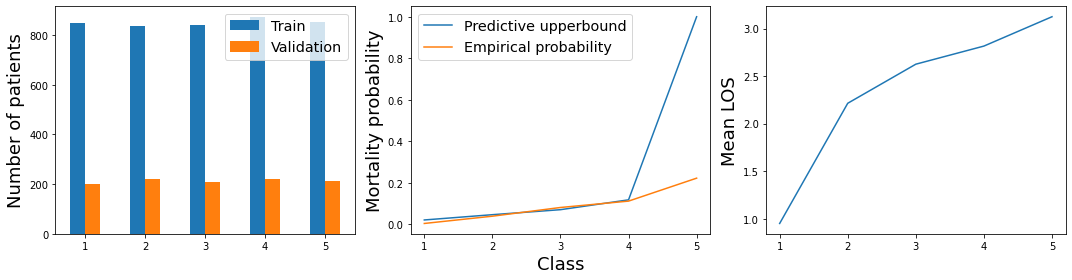

In [125]:
dir_path = './log/plot/'
fig, axs = plt.subplots(1,3, figsize=(15,4))

x_axis_tick = [str(i) for i in range(1, num_class+1)]
x_label_size = 18
y_label_size = 18
tick_size = 16

df_net.plot(x='X', y=['Train','Validation'], kind='bar', ax=axs[0], rot=0)
axs[0].set_ylabel('Number of patients', fontsize = y_label_size)
axs[0].set_xlabel('')
axs[0].legend(fontsize="x-large")


axs[1].plot(x_axis_tick, class_boundary, label='Predictive upperbound')
axs[1].plot(x_axis_tick, result[4], label='Empirical probability')
axs[1].set_xlabel('Class', fontsize = x_label_size)
axs[1].set_ylabel('Mortality probability', fontsize = y_label_size)
axs[1].legend(fontsize="x-large")

axs[2].plot(x_axis_tick, mu_all)
axs[2].set_ylabel('Mean LOS', fontsize = y_label_size)
plt.tight_layout()

path = dir_path + 'netplot.png'
fig.savefig(path)


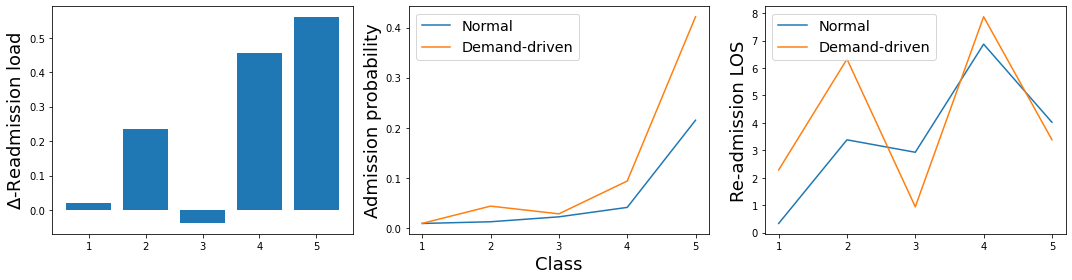

In [126]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].bar(x_axis_tick, result[3])
axs[0].set_ylabel(r'$\Delta$-Readmission load', fontsize = y_label_size)

axs[1].plot(x_axis_tick, p_r_low, label='Normal')
axs[1].plot(x_axis_tick, p_r_full, label='Demand-driven')
axs[1].set_xlabel('Class', fontsize = x_label_size)
axs[1].set_ylabel('Admission probability', fontsize = y_label_size)
axs[1].legend(fontsize="x-large")

axs[2].plot(x_axis_tick, mu_r_low, label='Normal')
axs[2].plot(x_axis_tick, mu_r_full, label='Demand-driven')
axs[2].set_ylabel('Re-admission LOS', fontsize = y_label_size)
axs[2].legend(loc=2,fontsize="x-large")

plt.tight_layout()
path = dir_path + 'deltaplot.png'
fig.savefig(path)